In [ ]:
!pip install imutils

In [1]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Input, Lambda, Input, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D, Dropout
import tensorflow as tf 
import tensorflow.keras as keras 

In [3]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

def save_loss_plot(fpath, history): 
    with plt.xkcd():
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")

        plt.title("Training Loss and val loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
    plt.savefig(fpath)
    plt.close()
    

def save_acc_plot(fpath, history): 
    with plt.xkcd():
        plt.plot(history.history["accuracy"], label="train_acc")
        plt.plot(history.history["val_accuracy"], label="val_acc")
        plt.title("Training and val Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
    plt.savefig(fpath)
    plt.close()

    
def create_dataset(images_files): 
    X = []
    y = []
    for image_file in images_files:
        try: 
            img = cv2.imread(image_file)
            img = cv2.resize(img, (224, 224))
            img = img / 255.0 

            label = image_file.split("/")[1].split("_")[0]

            X.append(img)
            y.append(label)
        
        except Exception as error:
            return error
    
    return np.array(X), np.array(y)

In [4]:
train_X, train_y = create_dataset(train_image_files)
train_X.shape

(2700, 224, 224, 3)

In [5]:
np.unique(train_y)

array(['airplane', 'car', 'elephant', 'lion', 'mouse', 'tiger cub'],
      dtype='<U9')

In [6]:
val_X, val_y = create_dataset(val_image_files)
val_X.shape

(292, 224, 224, 3)

In [7]:
test_X, test_y = create_dataset(test_image_files)
test_X.shape

(300, 224, 224, 3)

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
val_y = label_encoder.transform(val_y)
test_y = label_encoder.transform(test_y)

In [9]:
class ResenetSupervisedModel(keras.Model): 
    def __init__(self, input_dims, out_dims): 
        super(ResenetSupervisedModel, self).__init__()
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        self.base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=None)
        self.base_model.trainable = False 
        
        self.dense_1 = Dense(256, activation="relu")
        self.dropout = keras.layers.Dropout(0.4)
        self.dense_2 = Dense(128, activation='relu')
        self.globalavgpooling = GlobalAveragePooling2D()
        self.out = Dense(6, activation='softmax')
        
    def call(self, tensor): 
        x = self.base_model(tensor)
        x = self.globalavgpooling(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        
        out = self.out(x)
        return out 
    
    def build_graph(self):
        x = tf.keras.layers.Input(shape=self.input_dims)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [10]:
def create_tensorflow_dataset(X, y, batch_size): 
    tensorflow_data = tf.data.Dataset.from_tensor_slices((X, y))
    tensorflow_data = (
    tensorflow_data
        .shuffle(1024)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return tensorflow_data   

In [11]:
import pandas as pd 

onehot_train_y = pd.get_dummies(train_y)
onehot_val_y = pd.get_dummies(val_y)
onehot_test_y = pd.get_dummies(test_y)

train_ds = create_tensorflow_dataset(train_X, onehot_train_y, 32)
test_ds = create_tensorflow_dataset(test_X, onehot_test_y, 32)
val_ds = create_tensorflow_dataset(val_X, onehot_val_y, 32)

In [16]:
def train_step(X, y, model, optimizer, loss_func, metric_func): 
    with tf.GradientTape() as tape: 
        probs = model(X)
        y = tf.cast(y, dtype=tf.float32)
        loss_val = loss_func(y, probs)
        
    params = model.trainable_weights
    grads = tape.gradient(loss_val, params)
    optimizer.apply_gradients(zip(grads, params))
    metric_func.update_state(y, probs)
    
    return loss_val 


def val_step(X, y, model, loss_func, metric_func): 
    with tf.GradientTape() as tape: 
        preds_prob = model(X)
        y = tf.cast(y, dtype=tf.float32)
        
        y = tf.cast(y, dtype=tf.float32)
        loss_val = loss_function(preds_prob, y)
    metric_func.update_state(y, preds_prob)
    
    return loss_val


In [13]:
import tqdm 

def train(model, training_data, validation_data, optimizer, loss_function, 
                          metric_function, val_metric_function, batch_size, test_step, epochs): 
    
    # train step
    for epoch in range(epochs): 
        train_losses, val_losses = [], []
        
        for batch_indx, (training_X_batch, training_y_batch) in \
                    tqdm.tqdm(enumerate(training_data), total=len(training_data)): 
            train_loss = train_step(
                            training_X_batch, 
                            training_y_batch, 
                            model,
                            optimizer, 
                            loss_function,  
                            metric_function
                )
                        
            train_losses.append(train_loss)
    
        # val step
        for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
            
            val_loss_value = val_step(x_batch_val, y_batch_val, 
                                        model, loss_function, 
                                        val_metric_function)
            val_losses.append(float(val_loss_value))

        epoch_train_acc = metric_function.result()
        epoch_val_acc = val_metric_function.result()
        
        print(f"Epoch {epoch} loss: {np.mean(train_losses)} val_loss: {np.mean(val_losses)} accuracy: {epoch_train_acc} val_accuracy: {epoch_val_acc}")
        
        metric_function.reset_states()
        val_metric_function.reset_states()
        
    return model, train_losses, val_losses

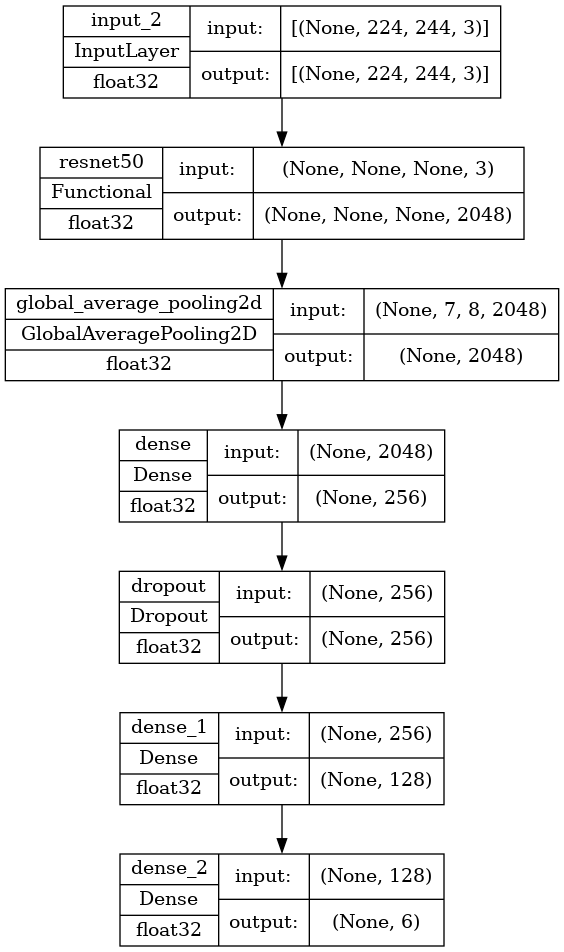

In [14]:
supervised_model = ResenetSupervisedModel((224, 244, 3), 6)
tf.keras.utils.plot_model(supervised_model.build_graph(),
                          show_shapes=True, show_dtype=True, 
                          show_layer_names=True,expand_nested=False)

In [17]:
optimizer = keras.optimizers.Adam()
loss_function = keras.losses.CategoricalCrossentropy()
train_metric_function = keras.metrics.CategoricalAccuracy()
test_metric_function = keras.metrics.CategoricalAccuracy()

trained_model, train_losses, val_losses = train(supervised_model, train_ds, val_ds, optimizer, loss_function, 
                                                  train_metric_function, test_metric_function, 32, 20, 10)

100%|██████████| 84/84 [00:21<00:00,  3.88it/s]


Epoch 0 loss: 1.780985713005066 val_loss: 13.36081674363878 accuracy: 0.2124255895614624 val_accuracy: 0.2083333283662796


100%|██████████| 84/84 [00:20<00:00,  4.00it/s]


Epoch 1 loss: 1.7492204904556274 val_loss: 13.152949651082357 accuracy: 0.2421875 val_accuracy: 0.375


100%|██████████| 84/84 [00:20<00:00,  4.03it/s]


Epoch 2 loss: 1.6705787181854248 val_loss: 12.680436134338379 accuracy: 0.3054315447807312 val_accuracy: 0.3263888955116272


100%|██████████| 84/84 [00:20<00:00,  4.01it/s]


Epoch 3 loss: 1.5911474227905273 val_loss: 12.280891418457031 accuracy: 0.3433779776096344 val_accuracy: 0.4201388955116272


100%|██████████| 84/84 [00:20<00:00,  4.06it/s]


Epoch 4 loss: 1.5288218259811401 val_loss: 11.974810600280762 accuracy: 0.3604910671710968 val_accuracy: 0.3993055522441864


100%|██████████| 84/84 [00:21<00:00,  3.99it/s]


Epoch 5 loss: 1.4946378469467163 val_loss: 11.759781837463379 accuracy: 0.3779761791229248 val_accuracy: 0.40625


100%|██████████| 84/84 [00:20<00:00,  4.06it/s]


Epoch 6 loss: 1.4783518314361572 val_loss: 11.745510631137424 accuracy: 0.3909970223903656 val_accuracy: 0.4548611044883728


100%|██████████| 84/84 [00:20<00:00,  4.01it/s]


Epoch 7 loss: 1.4560129642486572 val_loss: 11.607537693447536 accuracy: 0.3991815447807312 val_accuracy: 0.4756944477558136


100%|██████████| 84/84 [00:20<00:00,  4.05it/s]


Epoch 8 loss: 1.4481611251831055 val_loss: 11.54076459672716 accuracy: 0.4032738208770752 val_accuracy: 0.3888888955116272


100%|██████████| 84/84 [00:21<00:00,  3.99it/s]


Epoch 9 loss: 1.4264233112335205 val_loss: 11.421802626715767 accuracy: 0.4066220223903656 val_accuracy: 0.4791666567325592
